# Empirical orthogonal Functions

In [1]:
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
import utils as ut

plt.style.use("./../plotting.mplstyle")

In [2]:
da = xr.open_dataset("../AE_VAE/data/ssta_1950_2021.nc")['ssta']
da

<xarray.DataArray 'ssta' (time: 864, lat: 13, lon: 35)>
[393120 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
  * lat      (lat) float64 -30.0 -25.0 -20.0 -15.0 -10.0 ... 15.0 20.0 25.0 30.0
  * lon      (lon) float64 -60.0 -55.0 -50.0 -45.0 ... 95.0 100.0 105.0 110.0
    month    (time) int64 ...

## Define EOF for spatio-temporal data

In [3]:
class SpatioTemporalPCA:
    """PCA of spatio-temporal data.

    Wrapper for sklearn.decomposition.PCA with xarray.DataArray input.

    Args:
        ds (xr.DataArray or xr.Dataset): Input dataarray to perform PCA on.
            Array dimensions (time, 'lat', 'lon')
        n_components (int): Number of components for PCA
    """
    def __init__(self, ds, n_components, **kwargs):
        self.ds = ds

        self.X, self.ids_notNaN = ut.map2flatten(self.ds)

        # PCA
        self.pca = PCA(n_components=n_components)
        self.pca.fit(self.X.data)

        self.n_components = self.pca.n_components


    def eofs(self):
        """Return components of PCA.

        Return:
            components (xr.dataarray): Size (n_components, N_x, N_y)
        """
        # EOF maps
        eof_map = []
        for i, comp in enumerate(self.pca.components_):
            eof = ut.flattened2map(comp, self.ids_notNaN)
            eof = eof.drop(['time', 'month'])
            eof_map.append(eof)

        return xr.concat(eof_map, dim='eof')
    

    def principal_components(self):
        """Returns time evolution of components.

        Return:
            time_evolution (xr.Dataarray): Principal components of shape (n_components, time)
        """
        time_evolution = []
        for i, comp in enumerate(self.pca.components_):
            ts = self.X.data @ comp

            da_ts = xr.DataArray(
                data=ts,
                dims=['time'],
                coords=dict(time=self.X['time']),
            )
            time_evolution.append(da_ts)
        return xr.concat(time_evolution, dim='eof')
    

    def explained_variance(self):
        return self.pca.explained_variance_ratio_
    

    def reconstruction(self, z, newdim='x'):
        """Reconstruct the dataset from components and time-evolution.

        Args:
            z (np.ndarray): Low dimensional vector of size (time, n_components)
            newdim (str, optional): Name of dimension. Defaults to 'x'.

        Returns:
            _type_: _description_
        """
        reconstruction = z.T @ self.pca.components_

        rec_map = []
        for rec in reconstruction:
            x = ut.flattened2map(rec, self.ids_notNaN)
            rec_map.append(x)

        rec_map = xr.concat(rec_map, dim=newdim)

        return rec_map

In [4]:
pca = SpatioTemporalPCA(da, n_components=3)
print(f"Explained variance: {np.sum(pca.explained_variance())}")
eof = pca.eofs()
pc = pca.principal_components() 

Explained variance: 0.49969923482867223


### Plot EOF and PC

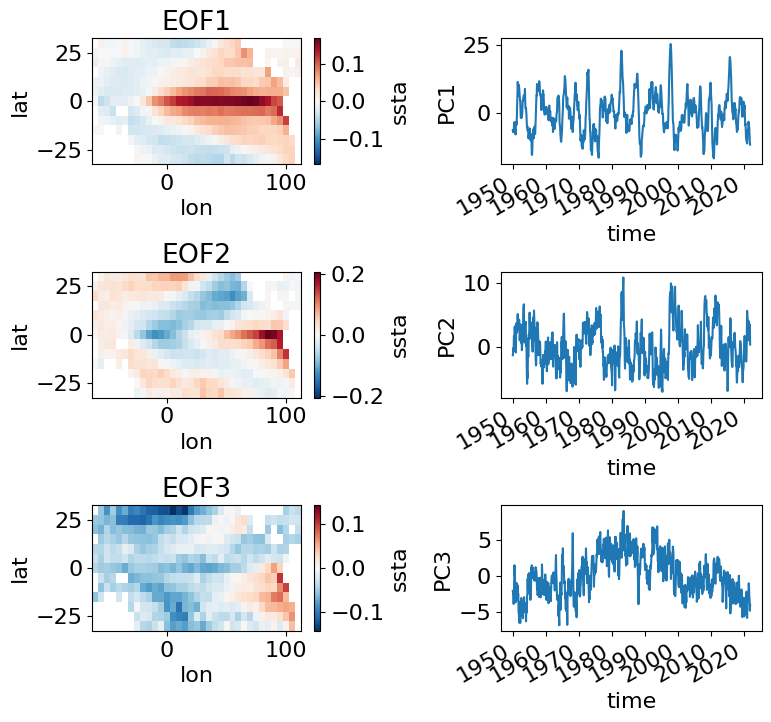

In [5]:
# Plot EOFs and PCs
fig = plt.figure(figsize=(2 * 4, 2.5* pca.n_components))
for i in range(pca.n_components):
    # Plot time evolution
    idx_plot = 2 * i + 1
    ax = fig.add_subplot(pca.n_components, 2, 2*i+1)
    eof[i].plot(ax=ax)
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(pca.n_components, 2, 2*i + 2)
    pc.isel(eof=i).plot(ax=ax)
    ax.set_ylabel(f"PC{i+1}")